In [ ]:
import sys
from pathlib import Path
from collections import Counter
import pandas as pd

# Garante que a raiz do projeto esteja no PYTHONPATH
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

from src.paths import *
from src.config import *
from src.io import *

create_project_structure()
set_global_seed()

## Síntese da Etapa Anterior

A etapa de entendimento estrutural dos dados permitiu concluir que:

- o dataset é numericamente rico, porém semanticamente complexo;
- a conversão de tipos deve ser feita de forma explícita e documentada;
- há indícios de regimes operacionais e redundância entre sensores;
- a dimensão temporal é central para o problema;
- a presença de variáveis alvo não garante viabilidade imediata de modelagem preditiva.

Diante disso, torna-se necessária uma etapa dedicada ao **condicionamento
e validação dos dados**, antes de qualquer análise exploratória aprofundada.

## Objetivo do Condicionamento dos Dados

Esta etapa tem como objetivos principais:

- converter variáveis para tipos adequados;
- realizar o parsing correto da variável temporal;
- preservar o máximo possível da informação original;
- identificar inconsistências evidentes;
- gerar um dataset condicionado e reutilizável.

Não é objetivo desta etapa:
- remover outliers de forma agressiva;
- aplicar normalizações ou escalonamentos;
- realizar análises exploratórias visuais.

Essas decisões pertencem às etapas subsequentes.

In [72]:
"""
Carregamento do dataset bruto, sem qualquer modificação.
"""

raw_path = RAW_DATA_DIR / "MiningProcess_Flotation_Plant_Database.csv"
df_raw = load_csv(raw_path)

df_raw.shape

(737453, 24)

## Preservação dos Dados Originais

Para evitar modificações acidentais nos dados brutos,
é criada uma cópia explícita do dataframe.

Essa prática facilita:
- auditoria das transformações;
- rastreabilidade;
- reprodutibilidade do projeto.

In [73]:
df = df_raw.copy()

## Conversão da Variável Temporal

A variável `date` está representada como texto.
Antes de qualquer ordenação ou análise temporal,
é necessário realizar seu parsing para o tipo adequado.

Essa conversão deve:
- ser explícita;
- falhar de forma visível caso existam valores inválidos;
- preservar o máximo de informação temporal disponível.

In [74]:
df["date"] = pd.to_datetime(
    df["date"],
    errors="coerce"
)

df["date"].isna().sum()

0

In [75]:
df["date"].head()

0   2017-03-10 01:00:00
1   2017-03-10 01:00:00
2   2017-03-10 01:00:00
3   2017-03-10 01:00:00
4   2017-03-10 01:00:00
Name: date, dtype: datetime64[ns]

A conversão da coluna `date` para o tipo `datetime64[ns]` não gerou valores ausentes,\
indicando que **100% dos timestamps presentes no dataset são válidos e consistentes**.
\
Isso sugere que:
- o dado temporal foi exportado de forma padronizada;
- não há registros corrompidos ou mal formatados nessa variável;
- o eixo temporal pode ser utilizado com segurança nas próximas etapas.

A inspeção da coluna `date` mostra que múltiplas linhas compartilham\
o mesmo timestamp exato.
\
Esse padrão indica que:
- os dados não representam uma série temporal univariada clássica;
- há múltiplas medições associadas ao mesmo instante;
- o processo pode estar sendo monitorado em alta frequência,\
  ou com múltiplos sensores reportando simultaneamente.

Essa característica impacta diretamente a forma como análises temporais,\
agregações e defasagens devem ser construídas.


## Identificação das Variáveis Numéricas

Com exceção da variável temporal, todas as demais colunas representam
medições de processo ou variáveis alvo.

Entretanto, essas variáveis estão codificadas como texto,
utilizando vírgula como separador decimal.

A conversão para tipos numéricos será feita de forma sistemática
e documentada.

In [76]:
numeric_cols = df.columns.drop("date")

In [77]:
"""
Conversão de colunas numéricas codificadas como string.

A estratégia adotada consiste em:
- substituir vírgula por ponto;
- converter explicitamente para float;
- introduzir NaN apenas quando a conversão não for possível.
"""

for col in numeric_cols:
    df[col] = (
        df[col]
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

Após a conversão das colunas numéricas de `object` para `float64`,\
não foram introduzidos valores ausentes em nenhuma variável.
\
Isso permite concluir que:
- todos os valores originalmente presentes são compatíveis com representação numérica;
- não há registros evidentemente inválidos (ex.: strings não numéricas);
- o uso de vírgula como separador decimal era consistente em todo o dataset.

## Validação Pós-Conversão

Após a conversão de tipos, é necessário validar:

- se todas as colunas numéricas foram convertidas corretamente;
- se surgiram valores ausentes inesperados;
- se os tipos estão coerentes com o esperado.

Essa validação reduz o risco de análises inconsistentes nas etapas seguintes.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

In [79]:
# verificação de valores ausentes após conversão
missing_after = (
    df.isna()
      .mean()
      .sort_values(ascending=False)
)

missing_after

date                            0.0
% Iron Feed                     0.0
% Iron Concentrate              0.0
Flotation Column 07 Level       0.0
Flotation Column 06 Level       0.0
Flotation Column 05 Level       0.0
Flotation Column 04 Level       0.0
Flotation Column 03 Level       0.0
Flotation Column 02 Level       0.0
Flotation Column 01 Level       0.0
Flotation Column 07 Air Flow    0.0
Flotation Column 06 Air Flow    0.0
Flotation Column 05 Air Flow    0.0
Flotation Column 04 Air Flow    0.0
Flotation Column 03 Air Flow    0.0
Flotation Column 02 Air Flow    0.0
Flotation Column 01 Air Flow    0.0
Ore Pulp Density                0.0
Ore Pulp pH                     0.0
Ore Pulp Flow                   0.0
Amina Flow                      0.0
Starch Flow                     0.0
% Silica Feed                   0.0
% Silica Concentrate            0.0
dtype: float64

A verificação de valores ausentes após o condicionamento confirma que\
nenhuma coluna contém `NaN`.
\
Esse resultado indica que:
- o dataset é estruturalmente completo;
- não há falhas explícitas de coleta no nível de armazenamento.

Entretanto, a ausência de valores nulos **não implica ausência de problemas de qualidade**,\
especialmente em dados industriais, onde falhas podem se manifestar de forma implícita.

## Impacto da Conversão nos Dados

Qualquer valor ausente identificado após a conversão
indica uma falha de parsing ou inconsistência no dado original.

Aqui, esses valores **não são tratados ou removidos**,
apenas documentados.

A decisão sobre imputação, exclusão ou uso explícito da ausência
como informação será tomada em etapas posteriores,
de forma contextualizada.

## Ordenação Temporal dos Dados

Para garantir consistência em análises futuras,
o dataset condicionado é explicitamente ordenado no tempo.

Essa ordenação é fundamental para:
- construção de defasagens (*lags*);
- janelas móveis;
- validação temporal de modelos.

Porém, os dados do atributo date não contabilizam minutos e nem segundos.\
Uma reordenação que não leve isso em consideração pode alterar a ordenação\
ooriginal das amostragens.

In [80]:
# 1. Garanta que a ordem atual (que é a correta de leitura) seja preservada
df['original_order'] = range(len(df))

# 2. Se precisar ordenar, use a data E o contador original
df = df.sort_values(by=['date', 'original_order'])

In [81]:
# Encontra onde o salto entre registros é maior que 1 minuto (60 segundos)
df['gap'] = df['date'].diff()
gaps_grandes = df[df['gap'] > pd.Timedelta(minutes=1)]

print(f"Total de gaps detectados: {len(gaps_grandes)}")
print("\nMaiores interrupções encontradas:")
print(gaps_grandes[['date', 'gap']].sort_values('gap', ascending=False).head(5))

Total de gaps detectados: 4096

Maiores interrupções encontradas:
                      date              gap
26814  2017-03-29 12:00:00 13 days 07:00:00
174    2017-03-10 02:00:00  0 days 01:00:00
489953 2017-07-14 17:00:00  0 days 01:00:00
490313 2017-07-14 19:00:00  0 days 01:00:00
490493 2017-07-14 20:00:00  0 days 01:00:00


In [82]:
# from plotly import express as px
# px.scatter(df,'date', '% Silica Concentrate')

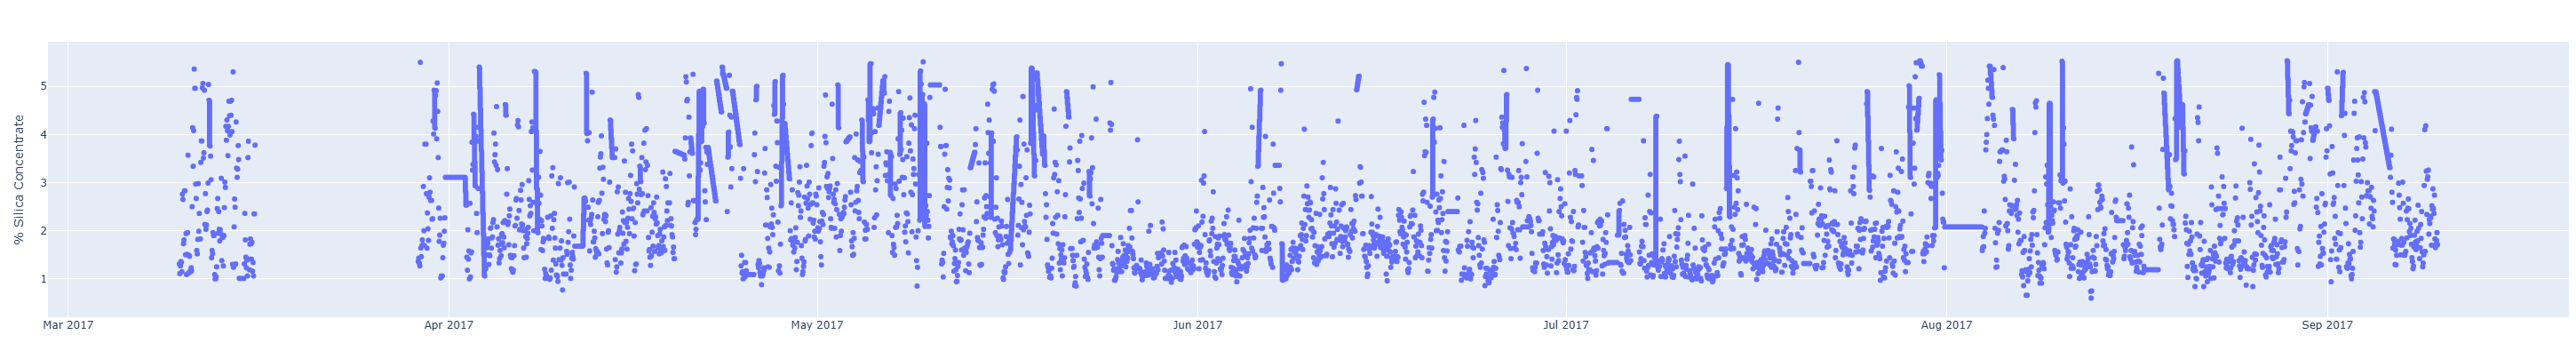

* Há um buraco nas datas das amostragens.

In [83]:
def corrigir_timestamps_sequenciais(dataframe, coluna_data='date'):
    """
    Atribui segundos sintéticos a registros com timestamps idênticos 
    baseando-se na ordem original das linhas.
    """
    nova_coluna = coluna_data+'_corrigida'

    # Criar uma cópia para evitar alterações no objeto original
    df_temp = dataframe.copy()
    
    # Gerar um contador sequencial para registros dentro do mesmo timestamp
    # O primeiro registro do minuto recebe 0, o segundo 1, e assim por diante
    df_temp['sequence'] = df_temp.groupby(coluna_data).cumcount()
    
    # Converter o contador em acréscimos de 20 segundos
    # segundos = contador * 20
    df_temp[nova_coluna] = df_temp[coluna_data] + pd.to_timedelta(df_temp['sequence'] * 20, unit='s')
    
    # Remover a coluna auxiliar de sequência
    df_temp = df_temp.drop(columns=['sequence'])
    
    return df_temp

In [84]:
# Aplicação da correção
df = corrigir_timestamps_sequenciais(df)

In [85]:
print(f"Nova data final: {df['date_corrigida'].max()}")
# O valor deve ser idêntico ou muito próximo de 2017-09-09 23:00:40

Nova data final: 2017-09-09 23:59:40


In [86]:
df[['date','original_order','date_corrigida']]

,date,original_order,date_corrigida
0,2017-03-10 01:00:00,0,2017-03-10 01:00:00
1,2017-03-10 01:00:00,1,2017-03-10 01:00:20
2,2017-03-10 01:00:00,2,2017-03-10 01:00:40
3,2017-03-10 01:00:00,3,2017-03-10 01:01:00
4,2017-03-10 01:00:00,4,2017-03-10 01:01:20
...,...,...,...
737448,2017-09-09 23:00:00,737448,2017-09-09 23:58:20
737449,2017-09-09 23:00:00,737449,2017-09-09 23:58:40
737450,2017-09-09 23:00:00,737450,2017-09-09 23:59:00
737451,2017-09-09 23:00:00,737451,2017-09-09 23:59:20


In [87]:
print(f"\nData final original: {df['date'].iloc[-1]}")
print(f"Data final reconstruída (20s): {df['date_corrigida'].iloc[-1]}")


Data final original: 2017-09-09 23:00:00
Data final reconstruída (20s): 2017-09-09 23:59:40


* Agora os dados estão datados corretamente

In [88]:
# 1. Calcula a diferença entre registros consecutivos
diffs = df['date'].diff().value_counts()

print("Frequências mais comuns encontradas:")
print(diffs.head())

# 2. Calcula a média teórica baseada no intervalo total
duracao_total = df['date'].max() - df['date'].min()
total_segundos = duracao_total.total_seconds()
frequencia_media = total_segundos / len(df)

print(f"\nIntervalo total: {duracao_total}")
print(f"Total de registros: {len(df)}")
print(f"Frequência média calculada: {frequencia_media:.2f} segundos")

Frequências mais comuns encontradas:
date
0 days 00:00:00     733356
0 days 01:00:00       4095
13 days 07:00:00         1
Name: count, dtype: int64

Intervalo total: 183 days 22:00:00
Total de registros: 737453
Frequência média calculada: 21.55 segundos


In [89]:
Counter(df.date)

Counter({Timestamp('2017-03-10 02:00:00'): 180,
         Timestamp('2017-03-10 03:00:00'): 180,
         Timestamp('2017-03-10 04:00:00'): 180,
         Timestamp('2017-03-10 05:00:00'): 180,
         Timestamp('2017-03-10 06:00:00'): 180,
         Timestamp('2017-03-10 07:00:00'): 180,
         Timestamp('2017-03-10 08:00:00'): 180,
         Timestamp('2017-03-10 09:00:00'): 180,
         Timestamp('2017-03-10 10:00:00'): 180,
         Timestamp('2017-03-10 11:00:00'): 180,
         Timestamp('2017-03-10 12:00:00'): 180,
         Timestamp('2017-03-10 13:00:00'): 180,
         Timestamp('2017-03-10 14:00:00'): 180,
         Timestamp('2017-03-10 15:00:00'): 180,
         Timestamp('2017-03-10 16:00:00'): 180,
         Timestamp('2017-03-10 17:00:00'): 180,
         Timestamp('2017-03-10 18:00:00'): 180,
         Timestamp('2017-03-10 19:00:00'): 180,
         Timestamp('2017-03-10 20:00:00'): 180,
         Timestamp('2017-03-10 21:00:00'): 180,
         Timestamp('2017-03-10 22:00:00'

In [90]:
Counter(df[df.date == '2017-03-10 01:00:00'].date)

Counter({Timestamp('2017-03-10 01:00:00'): 174})

Como pode ser observado acima:
* cada hora tem cerca de 180 medições;
* uma medição é feita a cada 20s, mais ou menos
* 3 medições por minuto

**Nota sobre a reconstrução temporal**
* A variável date_corrigida não representa o timestamp real de aquisição dos sensores.
* Trata-se de uma reconstrução sintética baseada na ordem original dos registros e na\
frequência média observada (~20s, tempo comum de aferimento dos sensores industriais),\
utilizada exclusivamente para viabilizar análises exploratórias dependentes de sequência\
temporal.
* As análises subsequentes devem ser interpretadas em termos de ordem relativa e dinâmica\
do processo, e não como eventos associados a um tempo absoluto preciso.
* A granularização do tempo permite que seja avaliada a possibilidade de prever o comportamento\
do target em intervalos menores do que 1h.

In [98]:
Counter(df.date_corrigida)

Counter({Timestamp('2017-03-10 01:00:00'): 1,
         Timestamp('2017-03-10 01:00:20'): 1,
         Timestamp('2017-03-10 01:00:40'): 1,
         Timestamp('2017-03-10 01:01:00'): 1,
         Timestamp('2017-03-10 01:01:20'): 1,
         Timestamp('2017-03-10 01:01:40'): 1,
         Timestamp('2017-03-10 01:02:00'): 1,
         Timestamp('2017-03-10 01:02:20'): 1,
         Timestamp('2017-03-10 01:02:40'): 1,
         Timestamp('2017-03-10 01:03:00'): 1,
         Timestamp('2017-03-10 01:03:20'): 1,
         Timestamp('2017-03-10 01:03:40'): 1,
         Timestamp('2017-03-10 01:04:00'): 1,
         Timestamp('2017-03-10 01:04:20'): 1,
         Timestamp('2017-03-10 01:04:40'): 1,
         Timestamp('2017-03-10 01:05:00'): 1,
         Timestamp('2017-03-10 01:05:20'): 1,
         Timestamp('2017-03-10 01:05:40'): 1,
         Timestamp('2017-03-10 01:06:00'): 1,
         Timestamp('2017-03-10 01:06:20'): 1,
         Timestamp('2017-03-10 01:06:40'): 1,
         Timestamp('2017-03-10 01:

In [91]:
df.drop(columns='gap', inplace=True)

# Dados duplicados

Em contextos industriais e de séries temporais, a presença de registros\
duplicados pode ser aceitável em estágios iniciais do projeto.\
\
Isso ocorre quando o objetivo principal é:
- compreender distribuições marginais;
- identificar escalas, limites operacionais e variabilidade;
- avaliar relações estatísticas globais;
- caracterizar o comportamento agregado do processo.

Aqui, registros duplicados podem representar:
- múltiplas leituras no mesmo instante;
- sensores diferentes reportando estados semelhantes;
- manutenção de valores constantes em regimes estáveis;
- repetição deliberada de estados operacionais controlados.

Nesses cenários, duplicatas **não são necessariamente erros**,\
mas parte da dinâmica do sistema.\
\
A presença de duplicatas torna-se problemática quando:
- assume-se independência estatística entre observações;
- realizam-se inferências probabilísticas finas;
- constrói-se validação temporal ou amostral;
- treinam-se modelos sensíveis à frequência relativa dos estados.

Por esse motivo, a identificação e o tratamento explícito de duplicatas\
devem ocorrer **antes da modelagem**, mas não necessariamente antes de\
uma EDA inicial.\
\
Aqui, a presença de múltiplos registros com **valores idênticos em todas as variáveis**\
associados ao **mesmo timestamp** não é compatível com a dinâmica física\
esperada de um processo industrial monitorado continuamente.\
\
Esse padrão indica que os registros duplicados **não representam medições\
independentes do processo**, mas sim um artefato introduzido em alguma etapa\
do pipeline de aquisição, agregação ou armazenamento dos dados.\
\
É importante distinguir dois fenômenos distintos:
- **Persistência física**: quando o processo permanece estável,\
  mas ainda assim gera medições independentes ao longo do tempo;
- **Duplicação artificial**: quando o mesmo registro é replicado\
  sem nova observação do processo.

No cenário observado, a repetição exata dos valores para o mesmo timestamp
é consistente com **duplicação artificial**, e não com persistência física.


In [92]:
sem_dates = df.drop(columns=['date','date_corrigida','original_order']).columns
sem_correcao = df.drop(columns=['date_corrigida','original_order']).columns

In [93]:
df[df.duplicated(subset=sem_correcao)].shape, df[df.duplicated(subset=sem_dates)].shape

((1171, 26), (1171, 26))

In [94]:
df[df.duplicated(subset=sem_dates)].head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,original_order,date_corrigida
8692,2017-03-12 01:00:00,58.84,11.46,3574.22,538.330,394.629,9.83691,1.74000,245.435,188.306,...,352.870,472.650,322.660,354.15,510.770,424.300,64.29,3.62,8692,2017-03-12 01:19:20
303866,2017-06-01 15:00:00,64.03,6.26,3128.91,570.679,395.215,9.87109,1.69214,299.927,297.070,...,502.969,598.362,453.516,472.02,454.208,484.443,66.39,1.22,303866,2017-06-01 15:11:00
303867,2017-06-01 15:00:00,64.03,6.26,3128.91,570.679,395.215,9.87109,1.69214,299.927,297.070,...,502.969,598.362,453.516,472.02,454.208,484.443,66.39,1.22,303867,2017-06-01 15:11:20
303868,2017-06-01 15:00:00,64.03,6.26,3128.91,570.679,395.215,9.87109,1.69214,299.927,297.070,...,502.969,598.362,453.516,472.02,454.208,484.443,66.39,1.22,303868,2017-06-01 15:11:40
303869,2017-06-01 15:00:00,64.03,6.26,3128.91,570.679,395.215,9.87109,1.69214,299.927,297.070,...,502.969,598.362,453.516,472.02,454.208,484.443,66.39,1.22,303869,2017-06-01 15:12:00


In [95]:
# Remoção de registros duplicados por timestamp.

n_before = df.shape[0] # quantidade antes da remoção

# Remoção de duplicatas por timestamp
df = (
    df
    # .sort_values("date")
    .drop_duplicates(keep="first", subset=sem_dates)
    .reset_index(drop=True)
)

n_after = df.shape[0] # quantidade após a remoção

print(f"Registros antes da deduplicação: {n_before}")
print(f"Registros após a deduplicação:  {n_after}")
print(f"Registros removidos:            {n_before - n_after}")


Registros antes da deduplicação: 737453
Registros após a deduplicação:  736282
Registros removidos:            1171


In [96]:
# 1. Calcula a diferença entre registros consecutivos
diffs = df['date'].diff().value_counts()

print("Frequências mais comuns encontradas:")
print(diffs.head())

# 2. Calcula a média teórica baseada no intervalo total
duracao_total = df['date'].max() - df['date'].min()
total_segundos = duracao_total.total_seconds()
frequencia_media = total_segundos / len(df)

print(f"\nIntervalo total: {duracao_total}")
print(f"Total de registros: {len(df)}")
print(f"Frequência média calculada: {frequencia_media:.2f} segundos")

Frequências mais comuns encontradas:
date
0 days 00:00:00     732185
0 days 01:00:00       4095
13 days 07:00:00         1
Name: count, dtype: int64

Intervalo total: 183 days 22:00:00
Total de registros: 736282
Frequência média calculada: 21.58 segundos


# Backup dos dados tratados

Com todas as variáveis numéricas representadas como `float64`\
e a variável temporal corretamente parseada, o dataset encontra-se\
tecnicamente apto para:
- cálculo de estatísticas descritivas confiáveis;
- análise de correlação;
- visualizações contínuas;
- construção de séries temporais;
- engenharia de atributos baseada em tempo.

Essa etapa conclui o condicionamento necessário para análises exploratórias
e modelagem subsequentes.

In [97]:
processed_path = PROCESSED_DATA_DIR / "mining_process_conditioned.parquet"
save_data(df, processed_path)

Salvando: C:\jupyter notebooks\IHM\data\processed\mining_process_conditioned.parquet (Compressão: Zstd)


# Síntese

Obteve-se:

- um dataset com tipagem adequada;
- variável temporal corretamente parseada;
- preservação dos dados brutos originais;
- remoção de entradas duplicadas inadequadas;
- rastreabilidade das transformações aplicadas.